# Estimating Gentrification using Street View Images and Embeddings

This script (initially produced by ChatGPT) does the following (_this was my query_):
 - Read a spatial boundary file (that I will hard code)
 - Obtain the road network (from OSM?) for that area
 - Generate sample points on the road network roughly X meters apart
 - At each sample point, download the most recent street images for that location (either a single 360 degree view of a few smaller images). Use whichever API service is the most appropriate for obtaining the images. Importantly please record the date that the image was taken.
 - For each image, calculate an embedding using an appropriate foundation model (one that has been pre-trained to distinguish street environments specifically). Please use Hugging Face libraries.
 - If necessary, calculate the mean embedding for each point (is this the best way to calculate a single embedding for a point represented by multiple images?)
 - Now, for each sampled point there will be a dataframe with information about the point and its embedding. Read another polygon spatial data file, that I will provide, which contains area-level estimates of gentrification.
 - Use point-in-polygon to get the gentrification for each point.
 - Use cross-validation to train a couple of ML models (probaly random forest, linear regression and a neural network) to estimate gentrification from the embedding vectors
 - Choose the best model and parameter configuration and test this model on some held-out data.

## Configuration and library loading

In [22]:
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from pathlib import Path
import pickle
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing
import json

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# File paths
data_dir = os.path.join("../../data/embeddings/")
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2011", "LSOA_2011_EW_BSC_V4.shp")
points_data_cache = data_dir + "points_with_embeddings_mean.pkl"
imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2019_Domains_of_Deprivation.xlsx")

def recreate_model(best_model_name, best_params):
    """
    Recreate a new sklearn pipeline with the same model type and hyperparameters
    """
    if best_model_name == "RandomForest":
        model = Pipeline([
            ('scaler', StandardScaler()),  # optional for RF
            ('reg', RandomForestRegressor(
                n_estimators=best_params.get('reg__n_estimators', 100),
                max_depth=best_params.get('reg__max_depth', None),
                random_state=42
            ))
        ])
    elif best_model_name == "NeuralNet":
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('reg', MLPRegressor(
                hidden_layer_sizes=best_params.get('reg__hidden_layer_sizes', (100,)),
                alpha=best_params.get('reg__alpha', 1e-4),
                max_iter=2000,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=42
            ))
        ])
    elif best_model_name == "LinearReg":
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('reg', LinearRegression())
        ])
    else:
        raise ValueError(f"Unknown model type: {best_model_name}")
    
    return model

def evaluate_imd_model(y_true, y_pred, plot=True):
    """
    Evaluate regression predictions for IMD rank.
    
    Parameters:
    - y_true: array-like, true IMD ranks
    - y_pred: array-like, predicted IMD ranks
    - plot: bool, whether to show scatter plot of predicted vs actual
    
    Returns:
    - metrics: dictionary with RMSE, MAE, R2, Spearman correlation
    """
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    print("Model evaluation metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel("True IMD Rank")
        plt.ylabel("Predicted IMD Rank")
        plt.title("Predicted vs Actual IMD Rank")
        plt.grid(True)
        plt.show()

    return metrics

# Define diversity function
def embedding_diversity(embeddings_list):
    if len(embeddings_list) < 2:
        return 0.0  # trivial: only one point
    X = np.stack(embeddings_list)
    sim_matrix = cosine_similarity(X)
    n = len(X)
    mean_sim = (sim_matrix.sum() - n) / (n*(n-1))
    diversity = 1 - mean_sim  # higher = more diverse
    return diversity

### Get the LSOA spatial data

In [20]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)

## Load the Embeddings

In [27]:
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [31]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get gentrification label for each point
points_labels_gdf = gpd.sjoin(points_labels_gdf, gm_lsoa, how='inner', predicate='within')
# sjoin may add an index from the polygon ('index_right'); we can drop it
if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(point_records)}"
      f" `(some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 `(some points may lie outside the label polygons and were dropped)


# Aggregating the image imbeddings

### Find a measure of the embedding diversity - based on cosine similarity

In [33]:
# Ensure embeddings are numpy arrays
points_labels_gdf['embedding'] = points_labels_gdf['embedding'].apply(np.array)

# Group by LSOA and compute diversity
lsoa_diversity = points_labels_gdf.groupby('LSOA11CD')['embedding'].apply(
    lambda x: embedding_diversity(list(x))).reset_index(name='diversity')

### Plot LSOA-level embedding diversity

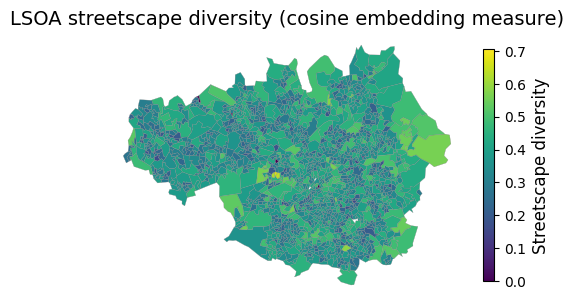

In [34]:
# Merge geometry into the diversity table
lsoa_diversity_gdf = lsoa_diversity.merge( gm_lsoa[['LSOA11CD', 'geometry']], on='LSOA11CD', how='left')
# Convert to a GeoDataFrame
lsoa_diversity_gdf = gpd.GeoDataFrame(lsoa_diversity_gdf, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot the LSOAs without the built-in legend
gdf_plot = lsoa_diversity_gdf.plot(column='diversity', cmap='viridis', linewidth=0.2, edgecolor='grey', legend=False, ax=ax)

# Create a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=lsoa_diversity_gdf['diversity'].min(), 
                                                                     vmax=lsoa_diversity_gdf['diversity'].max()))
sm._A = []  

# Add colorbar matching the plot
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)  # fraction controls height, pad controls distance
cbar.set_label("Streetscape diversity", fontsize=12)

ax.set_title("LSOA streetscape diversity (cosine embedding measure)", fontsize=14)
ax.axis('off');

### Find the mean embedding per LSOA

In [35]:
def mean_embed(x):
    return np.mean(np.vstack(x), axis=0)

avg_embeddings = (
    points_labels_gdf.groupby("LSOA11CD")["embedding"]
      .apply(mean_embed)
      .reset_index())
avg_embeddings_gdf = avg_embeddings.merge( gm_lsoa[['LSOA11CD', 'geometry']], on='LSOA11CD', how='left')

### Find the diversity of embedding per LSOA

In [36]:
lsoa_diversity_gdf = lsoa_diversity.merge( gm_lsoa[['LSOA11CD', 'geometry']], on='LSOA11CD', how='left')
lsoa_diversity_gdf = gpd.GeoDataFrame(lsoa_diversity_gdf, geometry='geometry')

# Running ML model to predict deprivation score from embeddings

### Get IMD data

In [37]:
# Read Excel file
imd = pd.read_excel(imd_file, sheet_name="IoD2019 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {
    "LSOA code (2011)": "LSOA11CD",
    "LSOA name (2011)": "lsoa_2011_name",
    "Local Authority District code (2019)": "lad_2019_code",
    "Local Authority District name (2019)": "lad_2019_name",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Join with embeddings, so we have for each LSOA an average embedding and an IMD ranking

In [38]:
avg_embeddings_with_imd_gdf = pd.merge(left=avg_embeddings_gdf, right=imd, on="LSOA11CD")
avg_embeddings_with_imd_gdf = gpd.GeoDataFrame(avg_embeddings_with_imd_gdf, geometry='geometry')
# avg_embeddings_with_imd_gdf.plot(column="imd_rank", legend=True)

### Build model

In [40]:
X = np.stack(avg_embeddings_with_imd_gdf["embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd_gdf['imd_rank'].values

print("Feature matrix shape:", X.shape, "Target vector shape:", y.shape)

Feature matrix shape: (1669, 768) Target vector shape: (1669,)


Model evaluation metrics:
RMSE: 5843.716
MAE: 4696.391
R2: 0.630
Spearman_rank_corr: 0.763


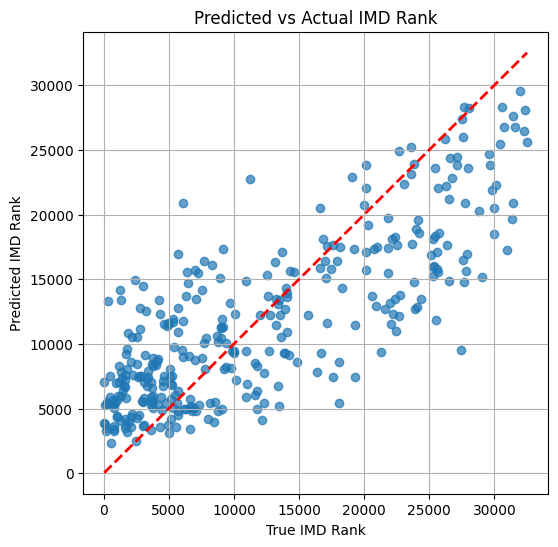

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)